In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

import keras
import tensorflow
from keras.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from model_persistence import get_persistence_dataset, train_test_split, calculate_errors, plot_error
from features_preprocessing import make_shifted_features


## Loading the dataset for the NN

In [244]:
def nn_univariate_dataset(start='2017-01-01', stop='2018-03-13', split='2017-12-31', shift_list=[0,1,2,3,7,14,30], normalize=True):
    
    #load the persistence dataset
    data = get_persistence_dataset(start=start, stop='2018-02-07')
    
    if normalize:
        data, scaler = normalize_df(data)

    #create the shifted features
    data = make_shifted_features(data, [0,1,2,3])
    
    #split into train and test sets
    train, test = train_test_split(data, split_date='2018-02-01')

    return train, test, scaler

    
    

In [245]:
train, test, scaler = nn_univariate_dataset()
test.shape

(6, 96)

## Shape the data for LSTM


(samples, timesteps, features)

Samples: length of train and test sets
Timesteps: 24 * number of days
- Training with 3 days autoregressive feautres 24 * 3: 72
- Target is always same as forecast horizon of 24 steps
Features: number of input series. In this case 1. I.e. adding temperature, and day type then 3

In [108]:
def prep_data(train, test, n_features=1):
    
    #split into X and Y train, test
    X_train, Y_train = make_xy_features(train)
    X_test, Y_test = make_xy_features(test)
    
    
    #get the details of the assets
    #number of autoregressive feautres * hours in day
    n_steps_in = X_train.shape[1]

    #number of steps ahead to forecast
    n_steps_out = Y_train.shape[1]

    #the number of samples in the test
    n_samples_train = X_train.shape[0] 
    n_samples_test = X_test.shape[0]    
    
    
    #reshape in preparation for the nn
    X_train = np.reshape(X_train.values, (n_samples_train, n_steps_in, n_features))
    X_test = np.reshape(X_test.values, (n_samples_test, n_steps_in, n_features))
    
    #convert to numpy arrays
    Y_train = Y_train.values
    Y_test = Y_test.values
    
    #set the input shape for the neural_network
    input_shape = (n_steps_in, n_features)

    
    return (X_train, X_test), (Y_train, Y_test), input_shape
    
    

In [156]:
#X[0]Y[0] is train, X[1]Y[1] is test data
X, Y, input_shape = prep_data(train, test)

X_train, X_test = X
Y_train, Y_test = Y

## Normalize the data

***Not an ideal workflow: data should be normalized before manipulating but because we have used dataframes to manipulate the data we do this step here. Alternatives:***
- Create two sets of cleaned data one normalized and one not.
- Have the load dataset function normalize and convert back to df before manipulating

Go with the latter and pass a scaler object back to the return so we can change scale back after modelling.



In [111]:
def normalize_df(data):
    
    #normalize the dataset for working with the lstm nn
    scaler = MinMaxScaler().fit(data.values)
    data_normd = scaler.transform(data.values)

    data = pd.DataFrame(data_normd, index=data.index, columns=data.columns)
    
    return data, scaler

    

## Define the LSTM

To start work with a vanilla LSTM

In [157]:
def vanilla_lstm(input_shape, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(50, activation='relu', input_shape=input_shape))
    model.add(keras.layers.Dense(n_steps_out))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

If using batch size the batch must split an entire training example. For simplicity we use batch gradient descent.

##### Learning rate search method
Search over range 1e-4 to 8.9e0. Find the range where learning rate reduced the most and reduce search area to find optimal.

In [187]:
print(1e-4 *(10**(np.arange(100)/30)))

[1.00000000e-04 1.07977516e-04 1.16591440e-04 1.25892541e-04
 1.35935639e-04 1.46779927e-04 1.58489319e-04 1.71132830e-04
 1.84784980e-04 1.99526231e-04 2.15443469e-04 2.32630507e-04
 2.51188643e-04 2.71227258e-04 2.92864456e-04 3.16227766e-04
 3.41454887e-04 3.68694506e-04 3.98107171e-04 4.29866235e-04
 4.64158883e-04 5.01187234e-04 5.41169527e-04 5.84341413e-04
 6.30957344e-04 6.81292069e-04 7.35642254e-04 7.94328235e-04
 8.57695899e-04 9.26118728e-04 1.00000000e-03 1.07977516e-03
 1.16591440e-03 1.25892541e-03 1.35935639e-03 1.46779927e-03
 1.58489319e-03 1.71132830e-03 1.84784980e-03 1.99526231e-03
 2.15443469e-03 2.32630507e-03 2.51188643e-03 2.71227258e-03
 2.92864456e-03 3.16227766e-03 3.41454887e-03 3.68694506e-03
 3.98107171e-03 4.29866235e-03 4.64158883e-03 5.01187234e-03
 5.41169527e-03 5.84341413e-03 6.30957344e-03 6.81292069e-03
 7.35642254e-03 7.94328235e-03 8.57695899e-03 9.26118728e-03
 1.00000000e-02 1.07977516e-02 1.16591440e-02 1.25892541e-02
 1.35935639e-02 1.467799

In [177]:
#set a learning rate scheduler to optimize the learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch : 1e-4 * 10**(epoch/20))

#initalize the model
vanilla_model = vanilla_lstm(input_shape)


history_vm = vanilla_model.fit(X_train, Y_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
29/29 [==============================] - 7s 227ms/step - loss: 0.4915
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4911
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4906
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4899
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4892
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4884
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4875
Epoch 8/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4865
Epoch 9/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4854
Epoch 10/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4842
Epoch 11/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4828
Epoch 12/100
29/29 [==============================] - 0s 7ms/step - loss: 0.4813
Epoch 13/100
29/29 [===============

In [201]:
def plot_loss(history, scale=20, semilog=True):
    fig = plt.figure(figsize=(8,7))
    
    #values for the x axis - same as the changes in the learning rate
    lrs = 1e-4 *(10**(np.arange(100)/scale))
    
    if semilog:
        #history values for the loss
        plt.semilogx(lrs, history.history['loss'])
        #set the y axis limits
        plt.ylim((0.01, 1))
        #label names
        plt.xlabel('Leaning rate semilog scale')
        plt.title('Loss ')
        
    else:
        plt.plot(history.history['loss'])
        plt.xlabel('Epochs')
        plt.ylim((0.01, 0.5))
    

    

    plt.ylabel('Loss')

    
    plt.show()

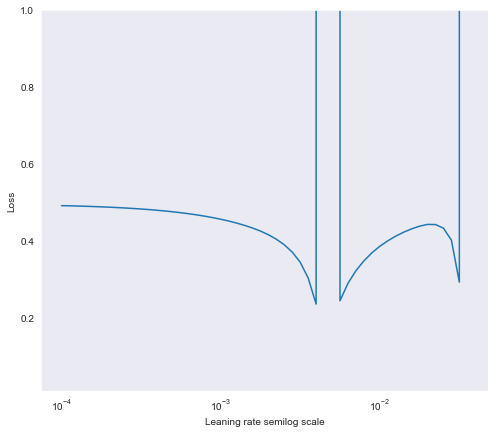

In [183]:
plot_loss(history_vm, 20)

In [188]:
#set a learning rate scheduler to optimize the learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch : 1e-4 * 10**(epoch/30))

#initalize the model
vanilla_model = vanilla_lstm(input_shape)


history_vm = vanilla_model.fit(X_train, Y_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
29/29 [==============================] - 7s 231ms/step - loss: 0.4704
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4699
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4694
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4688
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4682
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4675
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4668
Epoch 8/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4660
Epoch 9/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4652
Epoch 10/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4643
Epoch 11/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4633
Epoch 12/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4623
Epoch 13/100
29/29 [===============

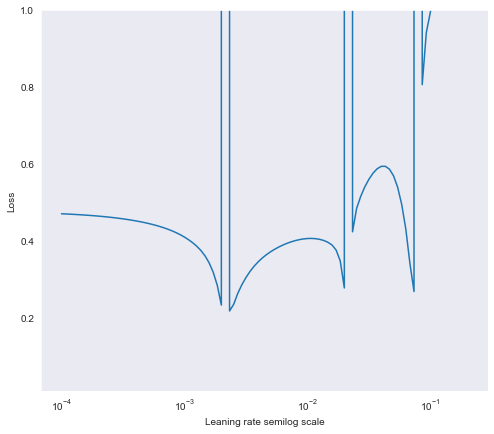

In [190]:
plot_loss_callbacks(history_vm, 30)

##### Long run

After some experimentation we will run the model for 500 epochs on a learning rate of 1e-3.

In [203]:
#initalize the model
vanilla_model = vanilla_lstm(input_shape, learning_rate=1e-3)


history_vm = vanilla_model.fit(X_train, Y_train, epochs=500)

Epoch 1/500
29/29 [==============================] - 5s 176ms/step - loss: 0.4708
Epoch 2/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4662
Epoch 3/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4616
Epoch 4/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4571
Epoch 5/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4525
Epoch 6/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4479
Epoch 7/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4434
Epoch 8/500
29/29 [==============================] - 0s 6ms/step - loss: 0.4386
Epoch 9/500
29/29 [==============================] - 0s 6ms/step - loss: 0.4339
Epoch 10/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4290
Epoch 11/500
29/29 [==============================] - 0s 6ms/step - loss: 0.4240
Epoch 12/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4188
Epoch 13/500
29/29 [===============

Epoch 103/500
29/29 [==============================] - 0s 8ms/step - loss: 0.2233
Epoch 104/500
29/29 [==============================] - 0s 7ms/step - loss: 0.2222
Epoch 105/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2212
Epoch 106/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2202
Epoch 107/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2192
Epoch 108/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2181
Epoch 109/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2171
Epoch 110/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2161
Epoch 111/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2151
Epoch 112/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2141
Epoch 113/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2131
Epoch 114/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2121
Epoch 115/500
29

Epoch 203/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0792
Epoch 204/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0785
Epoch 205/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0777
Epoch 206/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0770
Epoch 207/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0763
Epoch 208/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0756
Epoch 209/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0750
Epoch 210/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0744
Epoch 211/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0738
Epoch 212/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0733
Epoch 213/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0727
Epoch 214/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0722
Epoch 215/500
29

Epoch 303/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0726
Epoch 304/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0698
Epoch 305/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0615
Epoch 306/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 307/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0836
Epoch 308/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0499
Epoch 309/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0646
Epoch 310/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0732
Epoch 311/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0777
Epoch 312/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0796
Epoch 313/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0797
Epoch 314/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0783
Epoch 315/500
29

Epoch 403/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 404/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 405/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 406/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 407/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 408/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 409/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 410/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0420
Epoch 411/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0419
Epoch 412/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 413/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 414/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 415/500
29

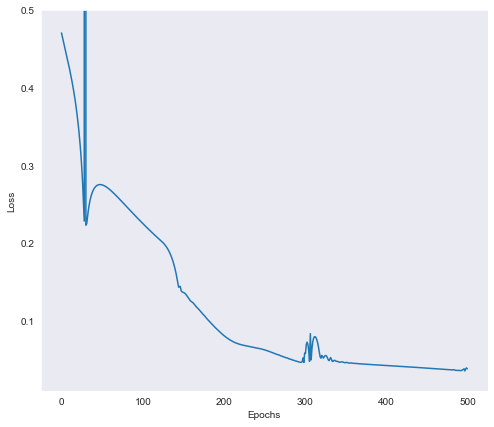

In [204]:
plot_loss(history_vm, semilog=False)

### Make predictions on the test data

In [206]:
Y_hat_test = vanilla_model.predict(X_test)

In [209]:
Y_hat_test.shape, Y_test.shape

((6, 24), (6, 24))

In [233]:
def plot_predictions(Y_hat_test, Y_test):
    fig = plt.figure(figsize=(8,7))

    
    #flatten the hourly slices into single univariate series
    #plot predictions
    plt.plot(Y_hat_test.flatten(), label='Predicted Load')
    #plot actual
    plt.plot(Y_test.flatten(), label='Actual Load')
    
    plt.xlabel('Hours')
    plt.ylabel('Normalized MWh')
    

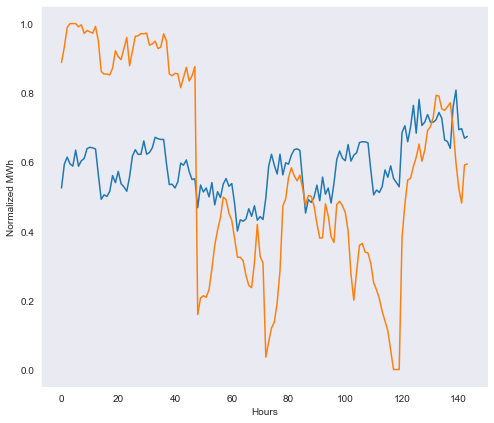

In [234]:
plot_predictions(Y_hat_test, Y_test)

##### Calculate RMSE: Small batch test run



In [255]:
def rescale_results(data, scaler):
    #function rescales the data so when calcualting RMSE we have comparable metrics
    
    return scaler.inverse_transform(data)
    

In [247]:
def convert_df(result, test):
    
    #convert the numpy results back to a dataframe so we can use the calculate_errors helper function
    
    y_cols = ['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23']
    
    index = test.index
    
    return pd.DataFrame(result, index=index, columns=y_cols)

In [256]:
Y_hat_test_df = convert_df(rescale_results(Y_hat_test, scaler), test)
Y_test_df = convert_df(rescale_results(Y_test, scaler), test)

In [257]:
error_model, errors_hourly = calculate_errors(Y_hat_test_df, Y_test_df, 'LSTM Small Batch')
print('Small batch LSTM 1 month training data, predicting 6 days total RMSE: {}'.format(error_model))

Small batch LSTM 1 month training data, predicting 6 days total RMSE: 3965.835409684048


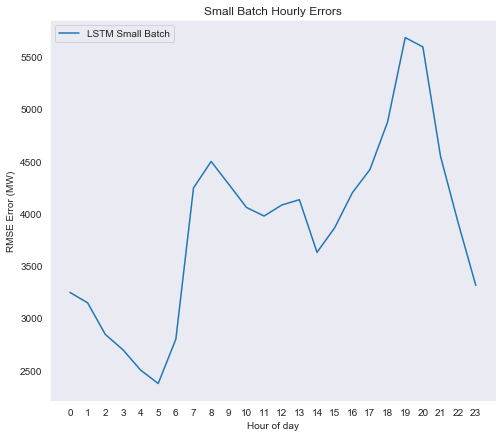

In [260]:
plot_error(errors_hourly, result_set=['LSTM Small Batch'], title='Small Batch Hourly Errors')

In [73]:
data = get_persistence_dataset(start='2018-01-01', stop='2018-02-07', shift=0)
data.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,22779.0,22009.0,20589.0,19547.0,18871.0,18688.0,18869.0,19263.0,19046.0,19563.0,...,23918.0,22626.0,22130.0,22607.0,25198.0,26477.0,27326.0,27534.0,26946.0,24878.0
2018-01-02,28084.0,26180.0,25063.0,24672.0,24537.0,25261.0,27911.0,32762.0,35344.0,36342.0,...,35554.0,35155.0,34958.0,35112.0,36077.0,37957.0,38313.0,37394.0,34645.0,31297.0


In [74]:
data = make_shifted_features(data, [0,1,2,3])
data.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-3 h_14,t-3 h_15,t-3 h_16,t-3 h_17,t-3 h_18,t-3 h_19,t-3 h_20,t-3 h_21,t-3 h_22,t-3 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,24890.0,22892.0,21436.0,20636.0,20276.0,20235.0,20708.0,21220.0,21777.0,23736.0,...,23918.0,22626.0,22130.0,22607.0,25198.0,26477.0,27326.0,27534.0,26946.0,24878.0
2018-01-05,24004.0,22300.0,21162.0,20561.0,20264.0,20037.0,20223.0,20090.0,21114.0,23050.0,...,35554.0,35155.0,34958.0,35112.0,36077.0,37957.0,38313.0,37394.0,34645.0,31297.0


In [31]:
data.columns

Index(['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23',
       't-1 h_0', 't-1 h_1', 't-1 h_2', 't-1 h_3', 't-1 h_4', 't-1 h_5',
       't-1 h_6', 't-1 h_7', 't-1 h_8', 't-1 h_9', 't-1 h_10', 't-1 h_11',
       't-1 h_12', 't-1 h_13', 't-1 h_14', 't-1 h_15', 't-1 h_16', 't-1 h_17',
       't-1 h_18', 't-1 h_19', 't-1 h_20', 't-1 h_21', 't-1 h_22', 't-1 h_23',
       't-2 h_0', 't-2 h_1', 't-2 h_2', 't-2 h_3', 't-2 h_4', 't-2 h_5',
       't-2 h_6', 't-2 h_7', 't-2 h_8', 't-2 h_9', 't-2 h_10', 't-2 h_11',
       't-2 h_12', 't-2 h_13', 't-2 h_14', 't-2 h_15', 't-2 h_16', 't-2 h_17',
       't-2 h_18', 't-2 h_19', 't-2 h_20', 't-2 h_21', 't-2 h_22', 't-2 h_23',
       't-3 h_0', 't-3 h_1', 't-3 h_2', 't-3 h_3', 't-3 h_4', 't-3 h_5',
       't

In [75]:
train, test = train_test_split(data, split_date='2018-02-01')

In [33]:
y_cols = ['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23']

def make_xy_features(data, y_cols= ['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23']):
    
    #extract the t-0 hours
    Y_data = data[y_cols]
    
    #drop the t-0 hours leaving only the auto regressive features. 
    X_data = data.drop(columns = y_cols)
    
    
    return X_data, Y_data
    
    

In [76]:
X_train, Y_train = make_xy_features(train, y_cols)
X_test, Y_test = make_xy_features(test, y_cols)

In [35]:
X_train.head(2)

,t-1 h_0,t-1 h_1,t-1 h_2,t-1 h_3,t-1 h_4,t-1 h_5,t-1 h_6,t-1 h_7,t-1 h_8,t-1 h_9,...,t-3 h_14,t-3 h_15,t-3 h_16,t-3 h_17,t-3 h_18,t-3 h_19,t-3 h_20,t-3 h_21,t-3 h_22,t-3 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,28930.0,26848.0,25598.0,25203.0,24987.0,25730.0,28433.0,32647.0,35564.0,36996.0,...,23918.0,22626.0,22130.0,22607.0,25198.0,26477.0,27326.0,27534.0,26946.0,24878.0
2018-01-05,24890.0,22892.0,21436.0,20636.0,20276.0,20235.0,20708.0,21220.0,21777.0,23736.0,...,35554.0,35155.0,34958.0,35112.0,36077.0,37957.0,38313.0,37394.0,34645.0,31297.0


In [36]:
Y_train.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,24890.0,22892.0,21436.0,20636.0,20276.0,20235.0,20708.0,21220.0,21777.0,23736.0,...,24932.0,23987.0,23262.0,22859.0,22924.0,23696.0,26026.0,28770.0,27734.0,26027.0
2018-01-05,24004.0,22300.0,21162.0,20561.0,20264.0,20037.0,20223.0,20090.0,21114.0,23050.0,...,25099.0,23834.0,23017.0,22735.0,22835.0,23281.0,24770.0,27316.0,26745.0,24843.0


In [38]:
X_test.head(2)

,t-1 h_0,t-1 h_1,t-1 h_2,t-1 h_3,t-1 h_4,t-1 h_5,t-1 h_6,t-1 h_7,t-1 h_8,t-1 h_9,...,t-3 h_14,t-3 h_15,t-3 h_16,t-3 h_17,t-3 h_18,t-3 h_19,t-3 h_20,t-3 h_21,t-3 h_22,t-3 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,22657.0,20818.0,19741.0,19276.0,19192.0,20003.0,22852.0,26479.0,29437.0,31639.0,...,34430.0,33799.0,33430.0,33438.0,34663.0,36846.0,37348.0,36600.0,33758.0,30372.0
2018-02-03,28904.0,26773.0,25649.0,25283.0,25106.0,25789.0,28342.0,33292.0,35998.0,37478.0,...,34052.0,33372.0,33102.0,33198.0,34434.0,36538.0,37134.0,36390.0,33770.0,30380.0


In [39]:
Y_test.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,28904.0,26773.0,25649.0,25283.0,25106.0,25789.0,28342.0,33292.0,35998.0,37478.0,...,36008.0,35299.0,34953.0,34723.0,35511.0,37468.0,37644.0,36901.0,34549.0,31734.0
2018-02-03,28838.0,26702.0,25497.0,25071.0,24925.0,25580.0,28170.0,32461.0,35469.0,36918.0,...,35909.0,35226.0,34984.0,34771.0,34690.0,36276.0,37210.0,36187.0,33867.0,31129.0


OK univariate features setup for input into a LSTM

## Setting up Vanilla LSTM

In [40]:
X_train.shape

(29, 72)

In [77]:
#number of channels of data. univariate is ONLY energy data
n_features = 1

#number of autoregressive feautres * hours in day
n_steps_in = X_train.shape[1]

#number of steps ahead to forecast
n_steps_out = Y_train.shape[1]

#the number of samples in the test
n_samples_train = X_train.shape[0] 
n_samples_test = X_test.shape[0]
 
print('Training samples: {}, Autoregressive features {} hours, Forecast horizon {} hours' .format(n_samples_train, n_steps_in, n_steps_out))
print('Test samples: {}, Autoregressive features {} hours, Forecast horizon {} hours' .format(n_samples_test, n_steps_in, n_steps_out))

Training samples: 29, Autoregressive features 72 hours, Forecast horizon 24 hours
Test samples: 6, Autoregressive features 72 hours, Forecast horizon 24 hours


In [83]:
## set up a vanilla model
model_vanilla = keras.models.Sequential()
model_vanilla.add(keras.layers.LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model_vanilla.add(keras.layers.Dense(n_steps_out))
model_vanilla.compile(optimizer='adam', loss='mse')

In [79]:
#reshape the dfs into input shape as np array
X_train = np.reshape(X_train.values, (n_samples_train, n_steps_in, n_features))
X_test = np.reshape(X_test.values, (n_samples_test, n_steps_in, n_features))

In [80]:
Y_train = Y_train.values
Y_test = Y_test.values

In [81]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((29, 72, 1), (29, 24), (6, 72, 1), (6, 24))

In [84]:
history = model_vanilla.fit(X_train, Y_train, epochs=5)

Epoch 1/5
29/29 [==============================] - 2s 57ms/step - loss: 1188704768.0000
Epoch 2/5
29/29 [==============================] - 0s 5ms/step - loss: 1341474432.0000
Epoch 3/5
29/29 [==============================] - 0s 5ms/step - loss: 1238581760.0000
Epoch 4/5
29/29 [==============================] - 0s 6ms/step - loss: 1152589952.0000
Epoch 5/5
29/29 [==============================] - 0s 5ms/step - loss: 1302741248.0000


In [ ]:
Y_test_hat = model_vanilla.predict(X_test)